<a href="https://colab.research.google.com/github/k-mammou/test/blob/main/FullModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import h5py
import tensorflow as tf

#Function to separate indices of dataset to training, validation & testing
#Returns: final index for each
#also num of total samples
def split_train_val_test(filename):
   with h5py.File(filename, 'r') as f:
      X1_dataset = f['X1_dataset']
      total_samples = X1_dataset.shape[0]
      print("Dataset samples: ", total_samples)
      train = total_samples * 0.8
      val = train + 0.1 * total_samples
      test = total_samples
   return train, val, test, total_samples

def datasetGenerator(filename, batchsize, startPoint, endPoint, limit):
  with h5py.File(filename,'r') as f:
    X1_dataset = f['X1_dataset']
    X2_dataset = f['X2_dataset']
    Y_dataset =  f['Y_dataset']

    #Check if we want limited version
    if limit is None:
      limit= endPoint
    if limit < endPoint:
      endPoint = limit

    while True:
      for start in range(startPoint, endPoint, batchsize): #example: batch size 5, end 100: [0,5], then        [5,10] etc
        batch_end = min(start + batchsize, endPoint)      #                               min(0+5,100)= 5, min(5+5,100)= 10
        batch_indices = np.arange(start, batch_end)

        #create batches!
        X1batch = X1_dataset[batch_indices]
        X2batch = X2_dataset[batch_indices]
        YBatch = Y_dataset[batch_indices]

        yield (X1batch, X2batch), YBatch



#Path to dataset
#final_path = "/content/drive/MyDrive/Thesis/test.hdf5"
final_path = "/content/drive/MyDrive/Thesis/Datasets2/final_dataset.hdf5"

#Parameters settings
batchsize = 64
limit = None
train, val, test, tot_samples = split_train_val_test(final_path)

print("\nTraining index:", int(train), "\nValidation index:", int(val), "\nTesting index:", int(test))


#create generators
TrainingDatasetGenerator = datasetGenerator(final_path, batchsize, 0, int(train), limit)
ValidationDatasetGenerator = datasetGenerator(final_path, batchsize, int(train), int(val), limit)
TestingDatasetGenerator = datasetGenerator(final_path, batchsize, int(val), int(test), limit)




tcount=0
#for [X1batch, X2batch], YBatch in TrainingDatasetGenerator:
 #  tcount+=1
 #  print(X1batch.shape, X2batch.shape, YBatch.shape)
 #  if tcount==3:
 #   break

print("\nExpected batches:", int(train)/ batchsize)
print("Generated batches:", tcount)

print("Training length:",   int(train))
print("Validation length:", int(val - train))
print("Testing length:",    int(test - val))



Dataset samples:  44981

Training index: 35984 
Validation index: 40482 
Testing index: 44981

Expected batches: 562.25
Generated batches: 0
Training length: 35984
Validation length: 4498
Testing length: 4498


In [ ]:
#VOL 2
import numpy as np
import h5py

#Function to separate indices of dataset to training, validation & testing
#Returns: final index for each
#also num of total samples
def split_train_val_test(filenames):
    # Calculate cumulative sizes for each file
    file_sizes = []
    total_samples = 0

    # Calculate size of each file and add to get total number of samples
    for filename in filenames:
        with h5py.File(filename, 'r') as f:
            file_size = len(f['X1_dataset'])
            file_sizes.append(file_size)
            total_samples += file_size
            print(f"Size: {file_size} for file:{filename}")
    print("Total samples: ", total_samples)
    train = total_samples * 0.8
    val = train + 0.1 * total_samples
    test = total_samples
    return int(train), int(val), int(test), total_samples

#########################################################################################################

def datasetGenerator(filenames, batchsize, startPoint, endPoint, limit):
    # Init list of file sizes
    file_sizes = []
    total_samples = 0

    # Calculate size of each file
    for filename in filenames:
        with h5py.File(filename, 'r') as f:
            file_size = len(f['X1_dataset'])
            file_sizes.append(file_size)
            total_samples += file_size

    # Adjust the endPoint based on limit, if provided
    if limit is None:
        limit = endPoint
    if limit < endPoint:
        endPoint = limit

    # Start from startPoint
    current_position = startPoint

    while True:
        # Find the current file and local position based on `current_position`
        file_index = 0
        cumulative_position = 0
        added_file_sizes_position = 0

        # Determine the correct file index and local position                                                         #helps locate the proper file to use (for validation for example)
        while file_index < len(file_sizes) and current_position >= added_file_sizes_position + file_sizes[file_index]:
            added_file_sizes_position += file_sizes[file_index]
            file_index += 1

        if file_index == len(file_sizes):
            # If we've reached beyond the last file, reset
            current_position = startPoint
            continue

        # Local position within the current file
        local_position = current_position - added_file_sizes_position
        filename = filenames[file_index]

        # Print the current filename being used
        #print(f"Using file with index {file_index}: {filename}")


        with h5py.File(filename, 'r') as f:
            X1_dataset = f['X1_dataset']
            X2_dataset = f['X2_dataset']
            Y_dataset = f['Y_dataset']

            # Calculate the number of samples in the current file
            num_samples = file_sizes[file_index]

            # Continue from the current position within this file
            while local_position < num_samples and current_position < endPoint:
                # Calculate batch indices
                batch_end = min(local_position + batchsize, num_samples)
                batch_indices = np.arange(local_position, batch_end)

                # Create batches
                X1batch = X1_dataset[batch_indices]
                X2batch = X2_dataset[batch_indices]
                YBatch = Y_dataset[batch_indices]

                # Yield the current batch
                yield (X1batch, X2batch), YBatch

                # Update positions
                local_position += batchsize
                current_position += batchsize

            # Move to the next file
            local_position = 0

        # If we've exhausted all files, reset the position to startPoint
        if current_position >= endPoint:
            current_position = startPoint

#######################################################################################################
final_path1 = "/content/drive/MyDrive/Thesis/Datasets2/final_dataset.hdf5"
final_path2 = "/content/drive/MyDrive/Thesis/Datasets2/final_dtset/final_dataset2.hdf5"
final_path3 = "/content/drive/MyDrive/Thesis/Datasets2/final_dtset/final_dataset3.hdf5"
final_path4 = "/content/drive/MyDrive/Thesis/Datasets2/final_dtset/final_dataset4.hdf5"

paths = [final_path1, final_path2,final_path3,final_path4]

#Parameters settings
batchsize = 64
limit = None
train, val, test, tot_samples = split_train_val_test(paths)

print("\nTraining index:", train, "\nValidation index:", val, "\nTesting index:", test)



#create generators
TrainingDatasetGenerator = datasetGenerator(paths, batchsize, 0, train, limit)
ValidationDatasetGenerator = datasetGenerator(paths, batchsize, train,val, limit)
TestingDatasetGenerator = datasetGenerator(paths, batchsize, val, test, limit)


tcount=0
#for X2batch, YBatch in TrainingDatasetGenerator:
#   tcount+=1
#   print(tcount)


Size: 44981 for file:/content/drive/MyDrive/Thesis/Datasets2/final_dataset.hdf5
Size: 44980 for file:/content/drive/MyDrive/Thesis/Datasets2/final_dtset/final_dataset2.hdf5
Size: 45438 for file:/content/drive/MyDrive/Thesis/Datasets2/final_dtset/final_dataset3.hdf5
Size: 36672 for file:/content/drive/MyDrive/Thesis/Datasets2/final_dtset/final_dataset4.hdf5
Total samples:  172071

Training index: 137656 
Validation index: 154863 
Testing index: 172071


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPooling3D
from keras.utils import plot_model
import matplotlib.pyplot as plt

import os
from time import time



In [ ]:
#first submodel
input1 = Input(shape=(10,71,128,3))
convlstm1 = ConvLSTM2D(filters = 16,kernel_size=(3,3),padding = "same", return_sequences= True, activation="relu")(input1)
pooling1 = MaxPooling3D(pool_size=(1, 3, 3), padding='same')(convlstm1)

convlstm2 = ConvLSTM2D(filters = 16,kernel_size=(3,3),padding = "same", return_sequences= True, activation="relu")(pooling1)
pooling2 = MaxPooling3D(pool_size=(1, 4, 4), padding='same')(convlstm2)


convlstm3 = ConvLSTM2D(filters = 16,kernel_size=(3,3),padding = "same", return_sequences= True, activation="relu")(pooling2)
pooling3 = MaxPooling3D(pool_size=(1, 1, 2), padding='same')(convlstm3)


convlstm4 = ConvLSTM2D(filters = 16,kernel_size=(3,3),padding = "same", return_sequences= True, activation="relu")(pooling3)
pooling4 = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(convlstm4)

convlstm5 = ConvLSTM2D(filters = 16,kernel_size=(3,3),padding = "same", return_sequences= False, activation="relu")(pooling4)

flat1 = Flatten()(convlstm5)
dense11 = Dense(64,activation='relu')(flat1)

drop11 = Dropout(0.5)(dense11)

dense12 = Dense(32, activation = 'relu') (drop11)
dense13 = Dense(32, activation = 'relu') (dense12)
dense14 = Dense(16, activation = 'relu') (dense13)


#second submodel
input2 = Input(shape=(10,2))
lstm1 = LSTM(units=20,activation = 'relu', return_sequences = True)(input2)
lstm2 = LSTM(units=20,activation = 'relu', return_sequences = True)(lstm1)
lstm3 = LSTM(units=10,activation = 'relu', return_sequences = True)(lstm2)
lstm4 = LSTM(units=10,activation = 'relu', return_sequences = False)(lstm3)

flat21 = Flatten()(lstm4)
dense21 = Dense(32, activation='relu')(flat21)

drop21 = Dropout(0.5)(dense21)
dense22 = Dense(16, activation = 'relu') (drop21)


####FUSION
merge = keras.layers.Maximum()([dense14,dense22])


hidden1 = Dense(16, activation = 'relu') (merge)
drop1 = Dropout(0.5) (hidden1)

output = Dense(2, activation = 'sigmoid')(drop1)





#create model
model = Model(inputs=[input1, input2], outputs=output)

#compile
#compile
model.compile(
    loss=keras.losses.MAE,
    optimizer= keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.MSE, keras.metrics.CosineSimilarity()]
)
#summary
#plot_model(model)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10, 71, 128, 3) │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_lstm2d (ConvLSTM2D)  │ (None, 10, 71, 128,    │         11,008 │ input_layer[0][0]      │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 10, 24, 43, 16) │              0 │ conv_lstm2d[0][0]      │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_lstm2d_1             │ (None, 10, 24, 43, 16) │         18,496 │ max_pooling3d[0][0]    │
│ (ConvLSTM2D)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 10, 6, 11, 16)  │              0 │ conv_lstm2d_1[0][0]    │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_lstm2d_2             │ (None, 10, 6, 11, 16)  │         18,496 │ max_pooling3d_1[0][0]  │
│ (ConvLSTM2D)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_2           │ (None, 10, 6, 6, 16)   │              0 │ conv_lstm2d_2[0][0]    │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_lstm2d_3             │ (None, 10, 6, 6, 16)   │         18,496 │ max_pooling3d_2[0][0]  │
│ (ConvLSTM2D)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 10, 2)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_3           │ (None, 10, 3, 3, 16)   │              0 │ conv_lstm2d_3[0][0]    │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 10, 20)         │          1,840 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_lstm2d_4             │ (None, 3, 3, 16)       │         18,496 │ max_pooling3d_3[0][0]  │
│ (ConvLSTM2D)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 10, 20)         │          3,280 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 144)            │              0 │ conv_lstm2d_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)        

 Total params: 106,322 (415.32 KB)

 Trainable params: 106,322 (415.32 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
#define some callbacks to improve training
early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, verbose = 1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", patience = 5, verbose = 1)


checkpoint_path = "/content/drive/MyDrive/Thesis/Models/training_full10.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                verbose=0)


epochs = 10
batch_size = 64

#start timer to see how long the training takes
start = time()

#Train
training_history = model.fit(
    TrainingDatasetGenerator,
    epochs= epochs,
    steps_per_epoch=(train // batch_size),
    validation_data=ValidationDatasetGenerator,
    validation_steps = ((val-train)// batch_size),
    callbacks= [early_stopping, reduce_lr, cp_callback],
    verbose=1
    #,sample_weight = sample_weights
)
finish = (time() - start) / 60
print("Training time: ", finish, " minutes")
model.save("/content/drive/MyDrive/Thesis/Models/Full_10.h5")
print("Saved model to disk")


Epoch 1/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 3980s 2s/step - cosine_similarity: 0.9754 - loss: 0.1157 - mean_squared_error: 0.0228 - val_cosine_similarity: 0.9880 - val_loss: 0.0863 - val_mean_squared_error: 0.0156 - learning_rate: 0.0010
Epoch 2/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 2235s 1s/step - cosine_similarity: 0.9843 - loss: 0.0921 - mean_squared_error: 0.0158 - val_cosine_similarity: 0.9969 - val_loss: 0.0446 - val_mean_squared_error: 0.0040 - learning_rate: 0.0010
Epoch 3/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 2189s 1s/step - cosine_similarity: 0.9902 - loss: 0.0677 - mean_squared_error: 0.0090 - val_cosine_similarity: 0.9932 - val_loss: 0.0554 - val_mean_squared_error: 0.0052 - learning_rate: 0.0010
Epoch 4/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 2261s 1s/step - cosine_similarity: 0.9912 - loss: 0.0625 - mean_squared_error: 0.0079 - val_cosine_similarity: 0.9969 - val_loss: 0.0425 - val_mean_squared_error: 0.0031 - learning_rate: 0.0010
Epoch 5/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 1938s 902ms/st

Training time:  368.89279020229975  minutes
Saved model to disk


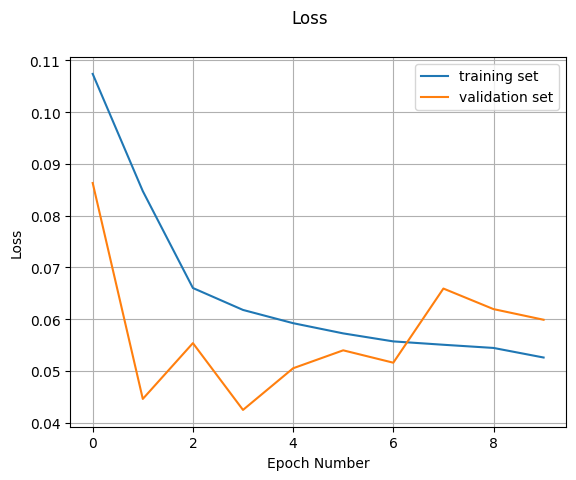

In [ ]:
#model.save("/content/drive/MyDrive/Thesis/Models/Full_5.h5")
#print("Saved model to disk")

#model evaluation!!

#LOSS FUNCTION
f1 = plt.figure("Loss")
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(training_history.history['loss'], label='training set')
plt.plot(training_history.history['val_loss'], label='validation set')
plt.suptitle('Loss')
plt.legend()
plt.grid()
plt.show()

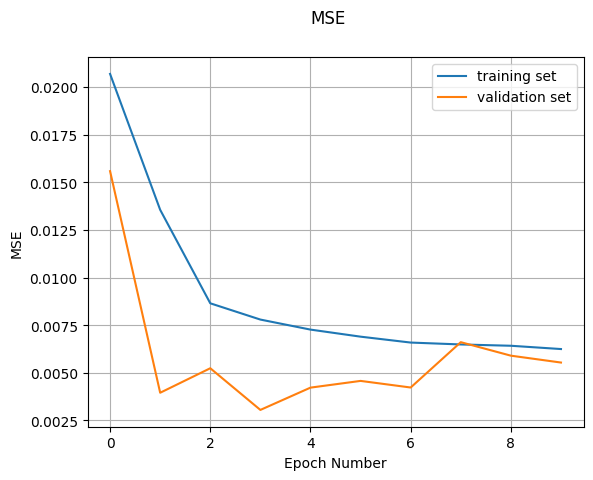

In [ ]:
f2 = plt.figure("MSE Metric")
plt.xlabel('Epoch Number')
plt.ylabel('MSE')
plt.plot(training_history.history['mean_squared_error'], label='training set')
plt.plot(training_history.history['val_mean_squared_error'], label='validation set')
plt.suptitle('MSE')
plt.legend()
plt.grid()
plt.show()

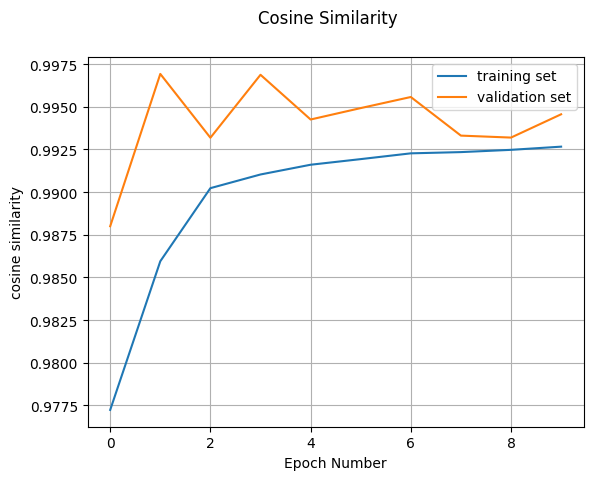

In [ ]:
f3 = plt.figure("Cosine Similarity")
plt.xlabel('Epoch Number')
plt.ylabel('cosine similarity')
plt.plot(training_history.history['cosine_similarity'], label='training set')
plt.plot(training_history.history['val_cosine_similarity'], label='validation set')
plt.legend()
plt.grid()
plt.suptitle('Cosine Similarity')
plt.show()

In [ ]:
TestingDatasetGenerator = datasetGenerator(paths, batchsize, val, test, limit)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(TestingDatasetGenerator,steps =((test-val)// batch_size))
print("test loss, test acc:", results)


Evaluate on test data
268/268 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - cosine_similarity: 0.9943 - loss: 0.0555 - mean_squared_error: 0.0050
test loss, test acc: [0.0576174333691597, 0.005168647039681673, 0.9942959547042847]


In [ ]:
filename = "/content/drive/MyDrive/Thesis/Datasets2/final_dataset.hdf5"

low, high = int(val), 24000
print(high,low)
#den trexei me ola auta....... na valw ligotera i na t kanw me generator?
low = 23000
with h5py.File(filename, 'r') as f:
    X1_dataset = f['X1_dataset']
    X2_dataset = f['X2_dataset']
    print(X2_dataset.shape)
    test_data1 = X1_dataset[low:high]
    test_data2= X2_dataset[low:high]
    print(test_data1.shape)
    test_predictions = model.predict((test_data1,test_data2))
    print("predictions shape:", test_predictions.shape)
    print("Predictions")

    print(test_predictions)
    #save data to files
    #np.save('/content/drive/MyDrive/Thesis/Datasets2/FULL_model_preds4.npy',test_predictions)

24000 154863
(44981, 10, 2)
(1000, 10, 71, 128, 3)
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step
predictions shape: (1000, 2)
Predictions
[[0.55136794 0.46691626]
 [0.55432403 0.46388793]
 [0.55883735 0.46123013]
 ...
 [0.64397234 0.35179672]
 [0.67981714 0.34750903]
 [0.6878581  0.3455249 ]]


In [ ]:
#Test predictions using unseen data!

test_predictions = model.predict(TestingDatasetGenerator, steps = (int(test-val)// batch_size))
print("predictions shape:", test_predictions.shape)
print("Predictions")
print(test_predictions)
#save data to files
np.save('/content/drive/MyDrive/Thesis/Datasets2/FULL_model_preds.npy',test_predictions)


70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 392ms/step
predictions shape: (4435, 2)
Predictions
[[0.4947557  0.39123592]
 [0.4537327  0.37663507]
 [0.38282204 0.35999843]
 ...
 [0.24140151 0.25510412]
 [0.31031314 0.23088388]
 [0.2915184  0.24092785]]
